In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

Import the training data. It's already been gapfilled, and outliers were removed.

In [2]:
data = pd.read_csv('trainingpts_cleaned.csv', index_col = 0)

We start by defining the names of phenospectral features and MODIS timeseries features, and set reasonable bounds for phenological parameters. These definitions will be useful for data exploration later.

In [3]:
# turn class column into categorical
data['class_num'] = data['class'].astype('int')
data['class'] = data['class'].astype('category')

# define columns into timeseries and phenological categories, but add in the class column
mod_ts_cols = [colname for colname in data if colname.startswith('mod')]
non_ts_cols = list(set(data.columns) - set(mod_ts_cols))
phenospectral_cols = ['EVI_at_infl2', 'quarterPeriod_first','EVI_at_min1','quarterPeriod_second','fittedAmplitude_second',
                     'EVI_at_infl1','peakDay_first','EVI_at_peak2','peakDiff', 'maxEVI_first','EVI_at_min2',
                     'peakDay_second', 'maxEVI_second', 'EVI_at_peak1', 'fittedAmplitude_first',]

# set reasonable limits for each phenological parameter
reasonable_limits = {'peakDay_second': [60, 365], 'fittedAmplitude_first': [0, 2],
                    'EVI_at_peak1': [0.1, 3], 'EVI_at_min1': [0, 0.5],
                    'maxEVI_first': [0.1, 3], 'EVI_at_min2': [0, 0.5],
                    'EVI_at_infl2': [0.1, 3], 'quarterPeriod_first': [10, 50],
                    'EVI_at_peak2': [0.1, 3], 'fittedAmplitude_second': [0, 2], 
                    'quarterPeriod_second': [10, 50], 'peakDiff': [0, 300],
                    'peakDay_first': [0, 200], 'EVI_at_infl1': [0.1, 3],
                    'maxEVI_second': [0.1, 3]}

First, we use boxplots and t-tests to see if phenological parameters differ for irrigated vs nonirrigated points.

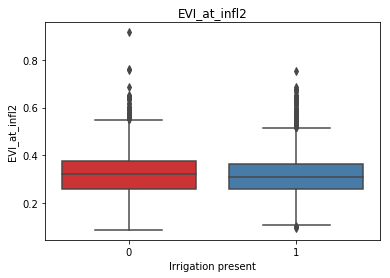

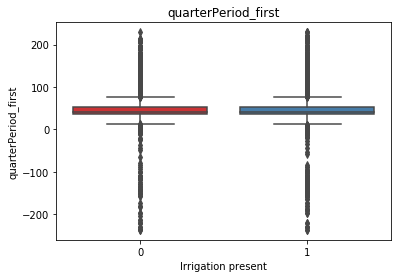

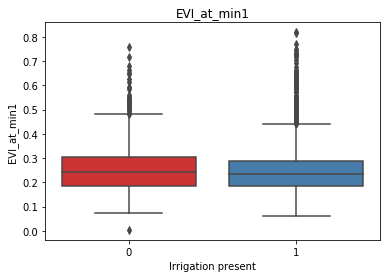

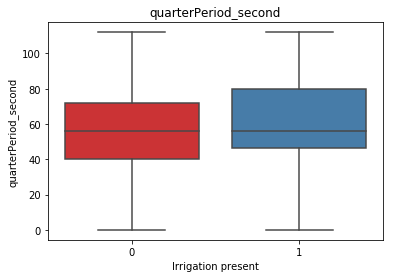

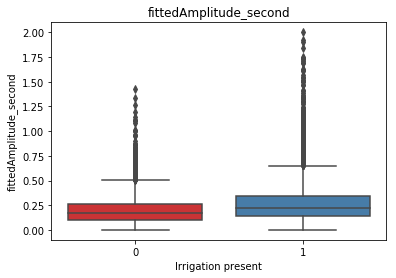

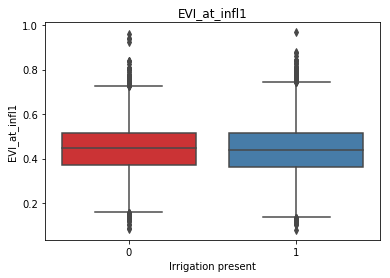

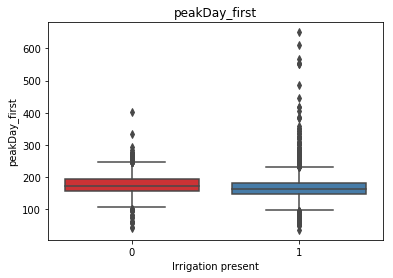

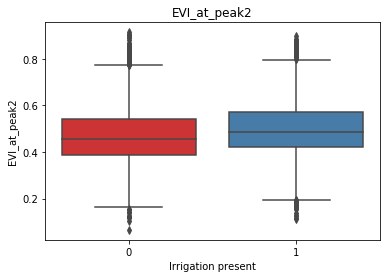

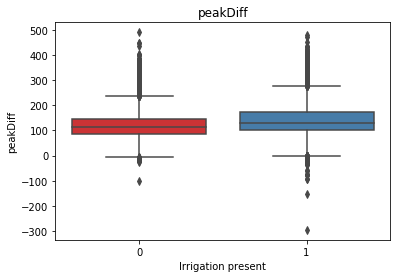

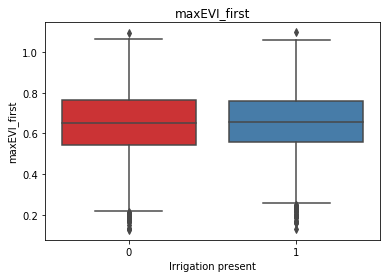

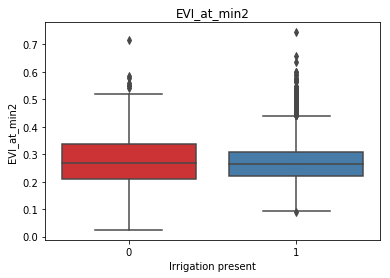

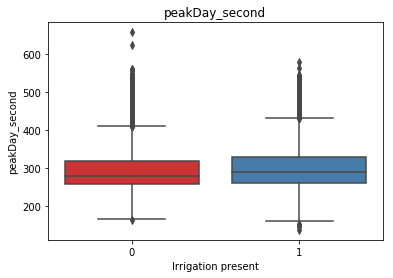

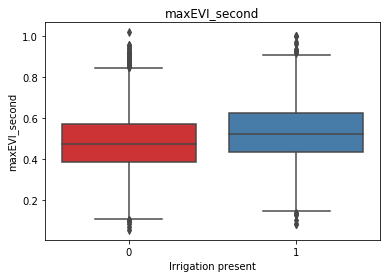

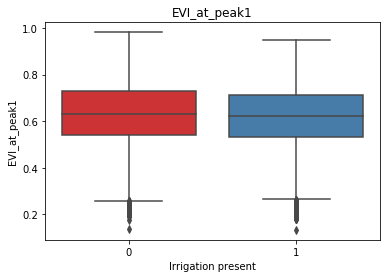

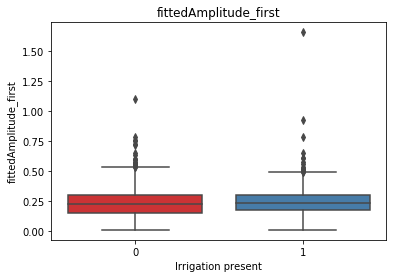

In [5]:
for colname in phenospectral_cols:
    sns.boxplot(x = 'class', y = colname, data = data, palette = 'Set1')
    plt.title(colname)
    plt.xlabel('Irrigation present')
    plt.ylabel(colname)
    lower_limit = reasonable_limits[colname][0]
    upper_limit = reasonable_limits[colname][1]
    #plt.axhline(lower_limit, color = 'red')
    #plt.axhline(upper_limit, color = 'red')
    plt.show()
    


In [6]:
# initialize dataframe to store statistical test results
t_test_results = pd.DataFrame(columns=['feature', 'region', 't_stat', 'p_value'])

for colname in phenospectral_cols:
    irrigated = data[data['class'] == 1][colname]
    nonirrigated = data[data['class'] == 0][colname]
    t_stat, p_value = stats.ttest_ind(irrigated, nonirrigated, nan_policy = 'omit', equal_var = False)
    
    t_test_results = t_test_results.append({'feature': colname, 'region': 'Brazil', 
                                            't_stat': t_stat, 'p_value': p_value}, ignore_index = True)

print(t_test_results)

                   feature  region     t_stat        p_value
0             EVI_at_infl2  Brazil  -2.953439   3.148796e-03
1      quarterPeriod_first  Brazil   3.150276   1.635599e-03
2              EVI_at_min1  Brazil  -0.878611   3.796302e-01
3     quarterPeriod_second  Brazil   8.645065   6.078808e-18
4   fittedAmplitude_second  Brazil  23.338571  1.896268e-117
5             EVI_at_infl1  Brazil  -0.729718   4.655770e-01
6            peakDay_first  Brazil -16.466785   3.200544e-60
7             EVI_at_peak2  Brazil  13.380565   1.559807e-40
8                 peakDiff  Brazil  16.036257   2.933265e-57
9             maxEVI_first  Brazil   2.540953   1.106794e-02
10             EVI_at_min2  Brazil  -2.996019   2.741355e-03
11          peakDay_second  Brazil  10.031754   1.378275e-23
12           maxEVI_second  Brazil  18.415258   1.104257e-74
13            EVI_at_peak1  Brazil  -3.379251   7.292094e-04
14   fittedAmplitude_first  Brazil   3.108334   1.886044e-03


Some phenological parameters appear to differentiate irrigated from rainfed points: fittedAmplitude_first, fittedAmplitude_second, peakDay_first, peakDay_second, EVI_at_peak2, peakDiff, and maxEVI_second. These tend to capture the height of the peak, which tends to be higher for irrigated points, and the timing of the peaks. However, even these don't separate the two classes well. We can introduce more features that capture the peak: max EVI during the entire year, the date of the max EVI during the entire year, and the maxEVI - minEVI.

Other phenological parameters don't differentiate irrigated from rainfed points:  EVI_at_min1, EVI_at_min2, EVI_at_infl1,  EVI_at_infl2, quarterPeriod_second, maxEVI_first, EVI_at_peak1. These tend to correspond to EVI values at off-peak times. We can conclude that the most effective phenological parameters to separate irrigated from rainfed points will target the height and timing of the peak, not the cycle length or EVI values at off-peak times.

Below, we calculate new phenological features that focus on the timing and height of the peaks. These new features may better separate our two classes.

In [7]:
# calculate new phenological features based on the peak

# the order of the mod_ts_cols needs to be shuffled into chronological order before they can be interpolated
# first, create a list of integers representing the order to sort by
sort_order = [int(colname.split('_')[2]) for colname in mod_ts_cols]

# sort the names of the timeseries columns
sorted_mod_ts_cols = [x for _,x in sorted(zip(sort_order, mod_ts_cols))]
first_half_mod_ts_cols = sorted_mod_ts_cols[0:40] # get only first half of the year
second_half_mod_ts_cols = sorted_mod_ts_cols[41:92] # get only second half of the year

def calc_max_EVI(row, colnames):
    ts_data = row[colnames]
    maxEVI = ts_data.max()
    return maxEVI

def calc_max_min_EVI(row, colnames):
    ts_data = row[colnames]
    maxEVI = ts_data.max()
    minEVI = ts_data.min()
    max_min_EVI = maxEVI - minEVI
    return max_min_EVI

def calc_date_maxEVI(row, colnames):
    ts_data = row[colnames]
    idx_maxEVI = np.argmax(ts_data)[0]
    colname_maxEVI = mod_ts_cols[idx_maxEVI]
    date_maxEVI = int(colname_maxEVI.split('_')[2])
    return date_maxEVI

data['max_EVI_firstHalf'] = data.apply(calc_max_EVI, axis = 1, colnames = first_half_mod_ts_cols)
data['max_min_EVI_firstHalf'] = data.apply(calc_max_min_EVI, axis = 1, colnames = first_half_mod_ts_cols)
data['date_maxEVI_firstHalf'] = data.apply(calc_date_maxEVI, axis = 1, colnames = first_half_mod_ts_cols)
data['max_EVI_secondHalf'] = data.apply(calc_max_EVI, axis = 1, colnames = second_half_mod_ts_cols)
data['max_min_EVI_secondHalf'] = data.apply(calc_max_min_EVI, axis = 1, colnames = second_half_mod_ts_cols)
data['date_maxEVI_secondHalf'] = data.apply(calc_date_maxEVI, axis = 1, colnames = second_half_mod_ts_cols)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


As before, we use boxplots and t-tests to determine if these new phenological parameters can better separate irrigated from rainfed points.

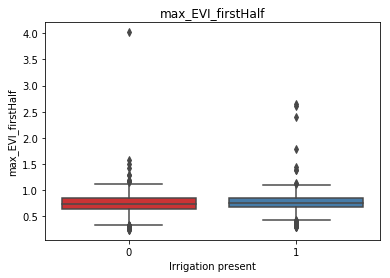

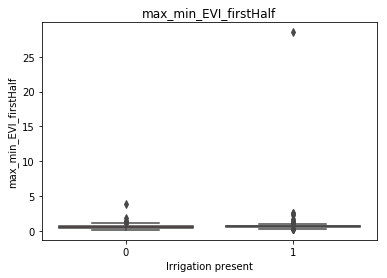

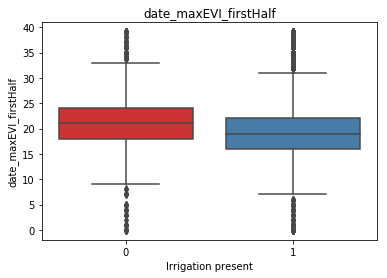

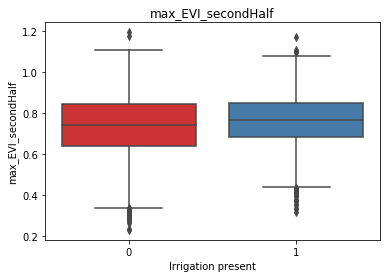

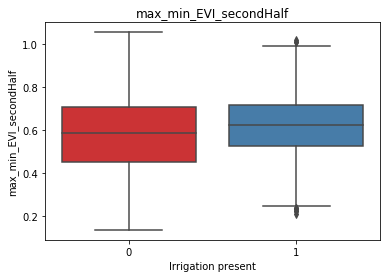

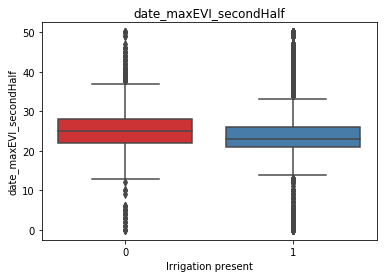

In [9]:
# check if these new phenological parameters can better separate irrigation from non-irrigation

new_phenospectral_cols = ['max_EVI_firstHalf', 'max_min_EVI_firstHalf', 'date_maxEVI_firstHalf',
                         'max_EVI_secondHalf', 'max_min_EVI_secondHalf', 'date_maxEVI_secondHalf']

for colname in new_phenospectral_cols:
    sns.boxplot(x = 'class', y = colname, data = data, palette = 'Set1')
    plt.title(colname)
    plt.xlabel('Irrigation present')
    plt.ylabel(colname)
    plt.show()

In [11]:
for colname in new_phenospectral_cols:
    irrigated = data[data['class'] == 1][colname]
    nonirrigated = data[data['class'] == 0][colname]
    t_stat, p_value = stats.ttest_ind(irrigated, nonirrigated, nan_policy = 'omit', equal_var = False)
    
    t_test_results = t_test_results.append({'feature': colname, 'region': 'Brazil', 
                                            't_stat': t_stat, 'p_value': p_value}, ignore_index = True)
print(t_test_results)

                   feature  region     t_stat        p_value
0             EVI_at_infl2  Brazil  -2.953439   3.148796e-03
1      quarterPeriod_first  Brazil   3.150276   1.635599e-03
2              EVI_at_min1  Brazil  -0.878611   3.796302e-01
3     quarterPeriod_second  Brazil   8.645065   6.078808e-18
4   fittedAmplitude_second  Brazil  23.338571  1.896268e-117
5             EVI_at_infl1  Brazil  -0.729718   4.655770e-01
6            peakDay_first  Brazil -16.466785   3.200544e-60
7             EVI_at_peak2  Brazil  13.380565   1.559807e-40
8                 peakDiff  Brazil  16.036257   2.933265e-57
9             maxEVI_first  Brazil   2.540953   1.106794e-02
10             EVI_at_min2  Brazil  -2.996019   2.741355e-03
11          peakDay_second  Brazil  10.031754   1.378275e-23
12           maxEVI_second  Brazil  18.415258   1.104257e-74
13            EVI_at_peak1  Brazil  -3.379251   7.292094e-04
14   fittedAmplitude_first  Brazil   3.108334   1.886044e-03
15       max_EVI_firstHa

The date of maxEVI in both the first and second halves of the year best separate irrigated from nonirrigated points. There's very little difference in the value of maxEVI or the maxEVI - minEVI value. Overall, these new peak-related predictors don't seem to be able to separate irrigated from nonirrigated points better than the original ones, so we will stick with the original features.

Next, we can look at whether the missingness of phenological parameters can help separate the two classes.

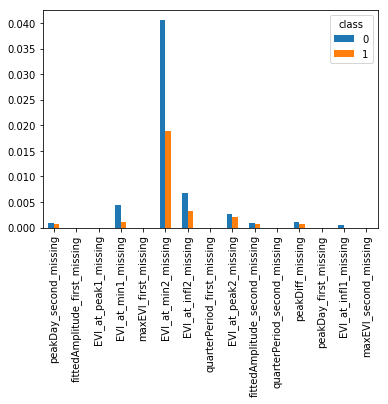

In [12]:
# get missing indicator column names
missingness_cols = [colname for colname in data if 'missing' in colname]

grouped_mean = data.groupby('class').mean()
grouped_std = data.groupby('class').std()

grouped_mean[missingness_cols].transpose().plot(kind = 'bar')

There are slightly more missing phenological values when there is no irrigation, so missingness may be an important predictor.

Next, we look at the average EVI timeseries profile for irrigated and rainfed points across Brazil to highlight potential times of the year during which the two classes experience different EVI values. Here, time is displayed as Modis acquisition, but spans from August 1, 2013 to July 31, 2014.

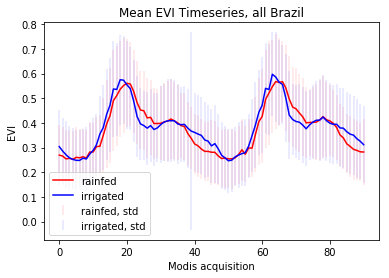

In [13]:
ts_mean = grouped_mean[sorted_mod_ts_cols].transpose()
ts_std = grouped_std[sorted_mod_ts_cols].transpose()
ts_mean.index = list(range(0, 91))
ts_std.index = list(range(0, 91))
ts_mean.index.name = 'modis_acquisition'
ts_std.index.name = 'modis_acquisition'
ts_mean.columns = ['0', '1']
ts_std.columns = ['0', '1']

plt.plot(ts_mean.index, ts_mean['0'], label = 'rainfed', color = 'red')
plt.plot(ts_mean.index, ts_mean['1'], label = 'irrigated', color = 'blue')
plt.errorbar(ts_mean.index, ts_mean['0'], ts_std['0'], linestyle = 'None', alpha = 0.1, color = 'red', label = 'rainfed, std')
plt.errorbar(ts_mean.index, ts_mean['1'], ts_std['1'], linestyle = 'None', alpha = 0.1, color = 'blue', label = 'irrigated, std')
plt.legend()
plt.title('Mean EVI Timeseries, all Brazil')
plt.ylabel('EVI')
plt.xlabel('Modis acquisition')
plt.show()

In [15]:
# t-tests to highlight the times of year that may best separate the two classes

for colname in sorted_mod_ts_cols:
    irrigated = data[data['class'] == 1][colname]
    nonirrigated = data[data['class'] == 0][colname]
    t_stat, p_value = stats.ttest_ind(irrigated, nonirrigated, nan_policy = 'omit', equal_var = False)
    
    t_test_results = t_test_results.append({'feature': colname, 'region': 'Brazil', 
                                            't_stat': t_stat, 'p_value': p_value}, ignore_index = True)

There is a slight difference in the EVI timeseries between irrigated and nonirrigated points. Irrigated points peak earlier and higher, and dip sooner for each peak. There appears to be a strange set of EVI measurements around modis acquisition 39. This timeseries indicates that certain acquisition times, corresponding to the peak and falling limb of each peak, are better able to distinguish between the two classes. Not all acquisition times are equally useful.

Next, we separate Brazil linto five regions and repeat the EVI timeseries plots. We expect that the different seasonality experienced in each region will impact the timing of agriculture, and therefore the times of year that best separate the two classes will differ by region.

In [16]:
# look at regional effect.
grouped_region = data.groupby(['region', 'class'])

regions = data['region'].unique()

grouped_ts_mean = grouped_region[sorted_mod_ts_cols].mean().transpose()
grouped_ts_std = grouped_region[sorted_mod_ts_cols].std().transpose()
grouped_ts_count = grouped_region[sorted_mod_ts_cols].count().transpose()

grouped_ts_mean.index = list(range(0, 91))
grouped_ts_std.index = list(range(0, 91))


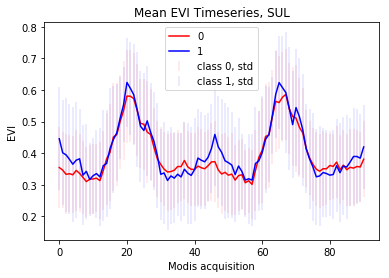

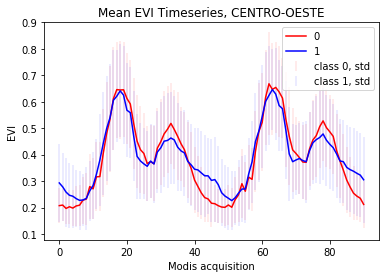

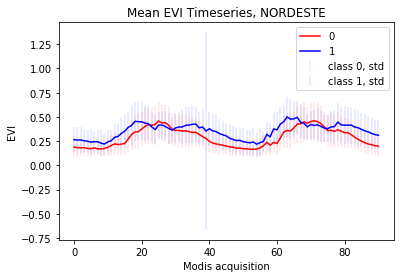

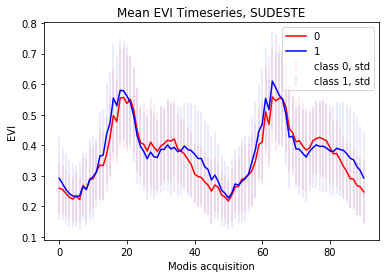

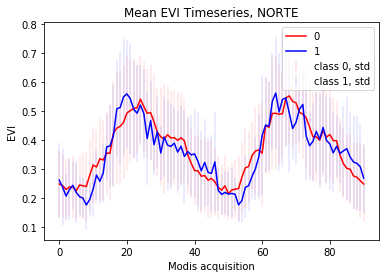

In [17]:
for regionname in regions:
    data_region_mean = grouped_ts_mean[regionname]
    data_region_std = grouped_ts_std[regionname]
    
    data_region_mean.columns = ['0', '1']
    data_region_std.columns = ['0', '1']

    plt.plot(data_region_mean.index, data_region_mean['0'], label = '0', color = 'red')
    plt.plot(data_region_mean.index, data_region_mean['1'], label = '1', color = 'blue')
    plt.errorbar(data_region_mean.index, data_region_mean['0'], data_region_std['0'], linestyle = 'None', alpha = 0.1, color = 'red', label = 'class 0, std')
    plt.errorbar(data_region_mean.index, data_region_mean['1'], data_region_std['1'], linestyle = 'None', alpha = 0.1, color = 'blue', label = 'class 1, std')
    plt.legend()
    plt.title('Mean EVI Timeseries, ' + regionname)
    plt.ylabel('EVI')
    plt.xlabel('Modis acquisition')
    plt.show()
    


Each region may have a different set of times that are best able to differentiate the two classes. In the south, southeast and center-west, the middle of the agricultural year (around modis acquisition 45) has higher EVI for irrigated points; in the northeast, the peak date is shifted for both the first and second peaks; in the north, the phenology of the two classes appear similar, but the first peak is a bit earlier for irrigated versus nonirrigated points. This analysis shows us that each region should be treated differently because the phenological differences between the two classes differ in space.

In [18]:
# repeat all the t-tests above, separated into regions

all_cols = sorted_mod_ts_cols + phenospectral_cols

for regionname in regions:
    for colname in all_cols:
        region_data = data[data.region == regionname]
        irrigated = region_data[region_data['class'] == 1][colname]
        nonirrigated = region_data[region_data['class'] == 0][colname]
        t_stat, p_value = stats.ttest_ind(irrigated, nonirrigated, nan_policy = 'omit', equal_var = False)

        t_test_results = t_test_results.append({'feature': colname, 'region': regionname, 
                                                't_stat': t_stat, 'p_value': p_value}, ignore_index = True)

Since the EVI timeseries looks different in each region, perhaps the phenological feature that best separate the regions will change as well. Below, we look at how well one peak-related phenological feature separates the two classes in each region.

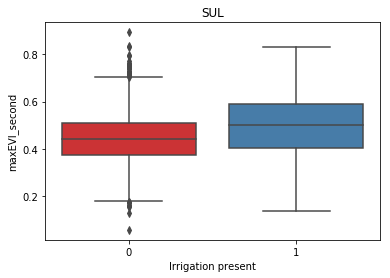

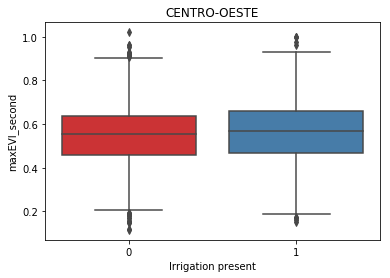

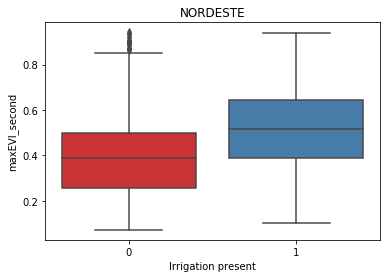

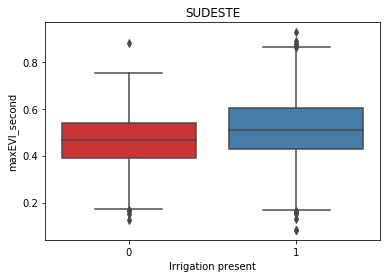

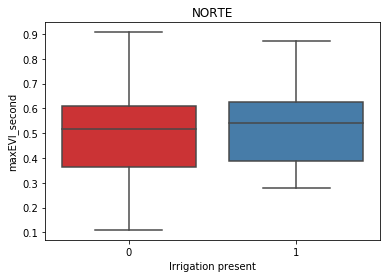

In [19]:
# if we split points into regions, will it be easier to see the difference between classes in the phenological predictors?

for regionname in regions:
    region_data = data[data['region'] == regionname]
    sns.boxplot(x = 'class', y = 'maxEVI_second', data = region_data, palette = 'Set1')
    plt.title(regionname)
    plt.xlabel('Irrigation present')
    plt.ylabel('maxEVI_second')
    plt.show()

Our chosen phenological feature is better able to distinguish the different classes in the south and northeast, and is completely unable to distinguish the classes in the north. This indiciates that certain regions may have greater prediction accuracy than others, and that the set of most informative predictors might be different for each region.

Since location is an important factor, we next look at the distribution of irrigation by location in three ways: (1) by latitude band, (2) region, and (3) state.

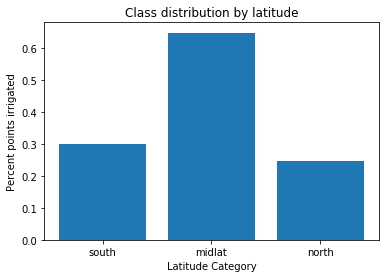

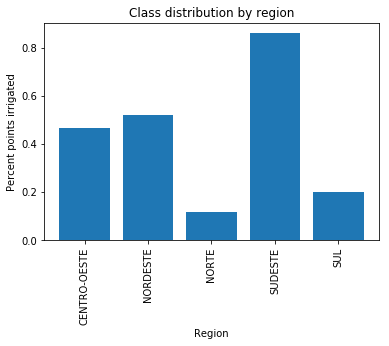

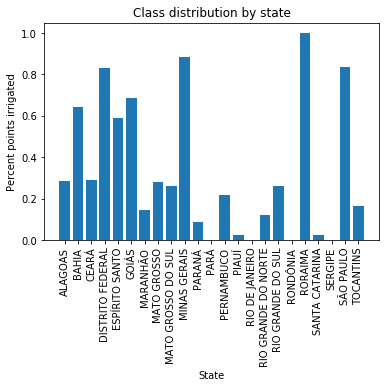

In [20]:
# how are the classes distributed across the latitudes and regions?

# create three latitude categories based on minimum and maximum latitude of the training points
min_lat = data.lat.min()
max_lat = data.lat.max()

data['latitude_cat'] = pd.cut(data.lat, bins = [-34, - 23, -12, 4], labels = ['south', 'midlat', 'north'])

# class distribution by latitude
class_dist_lat = data.groupby(['latitude_cat']).mean().loc[:, ['class_num']]
plt.bar(class_dist_lat.index, class_dist_lat['class_num'])
plt.xlabel('Latitude Category')
plt.ylabel('Percent points irrigated')
plt.title('Class distribution by latitude')
plt.show()

# class distribution by region
class_dist_lat = data.groupby(['region']).mean().loc[:, ['class_num']]
plt.bar(class_dist_lat.index, class_dist_lat['class_num'])
plt.xlabel('Region')
plt.ylabel('Percent points irrigated')
plt.xticks(rotation = 90)
plt.title('Class distribution by region')
plt.show()

# class distribution by state
class_dist_lat = data.groupby(['state']).mean().loc[:, ['class_num']]
plt.bar(class_dist_lat.index, class_dist_lat['class_num'])
plt.xlabel('State')
plt.ylabel('Percent points irrigated')
plt.xticks(rotation = 90)
plt.title('Class distribution by state')
plt.show()

There is a stark imbalance in irrigation over Brazil, especially at the state level: on state, Roraima, has nearly 100% irrigation, while other states have no irrigation. Including geographic features would therefore improve model performance, but would create a model that's less capable of predicting the spread of irrigation to new regions. In the map below, blue and red points indicate rainfed and irrigated training points, respectively.

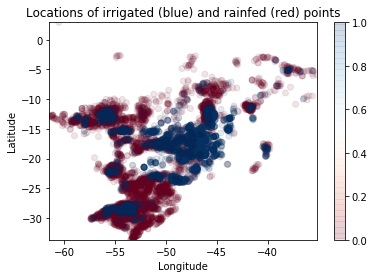

In [22]:
plt.scatter(x = 'lon', y = 'lat', c = 'class', data = data, alpha = 0.1, cmap = 'RdBu')
plt.title('Locations of irrigated (blue) and rainfed (red) points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.xlim([data.lon.min(), data.lon.max()])
plt.ylim([data.lat.min(), data.lat.max()])
plt.show()


A much higher percentage of points are irrigated in the midlatitude region than the north or the south. This could be back the midlatitude region has more established agriculture, whose managers can afford to invest in expensive irrigation equipment. The north has by far the lowest irrigation rate, likely because the wet season tends to last longer in the north (closer to the Amazon), and irrigation is less of a necessity. The northern area also has less established agriculture and less expansive transportation network, making it difficult to build irrigation structures. The variation in irrigation frequency is largest at the state level; Roraima has almost 100% irrigation, while Para, Rio de Janeiro, and Sergipe have none. Since the physical location of the points impacts how the two classes can be distinguished, it will be important to keep in mind these regional imbalances in irrigation frequency.

Geography may also impact the phenological features that best separate the two classes. Below, latitude and longitude are plotted against selected phenological features, along with a map of the phenological values. It shows that irrigated points are more concentrated in the center of the country compared to the edges, while rainfed points are spread across the agricultural area of the country. 

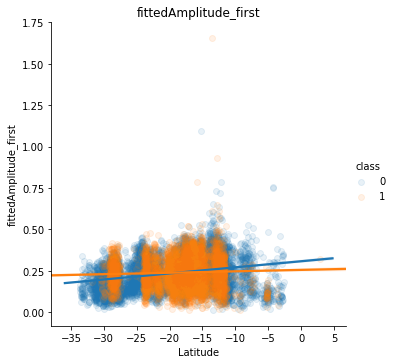

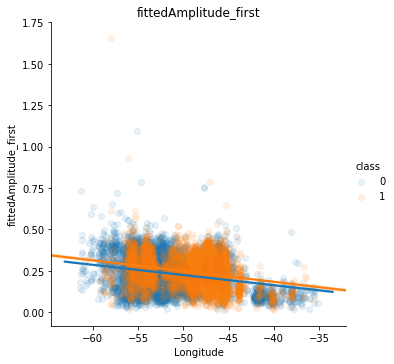

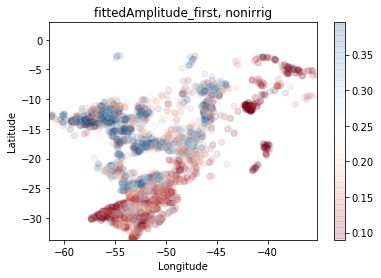

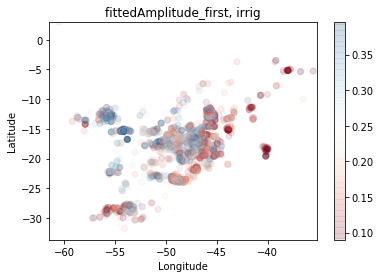

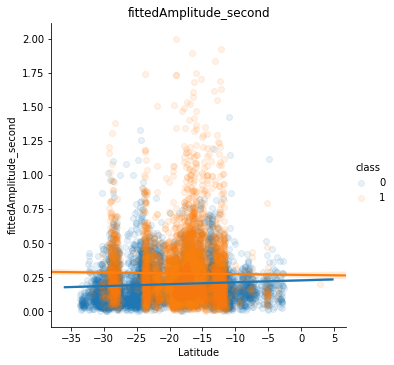

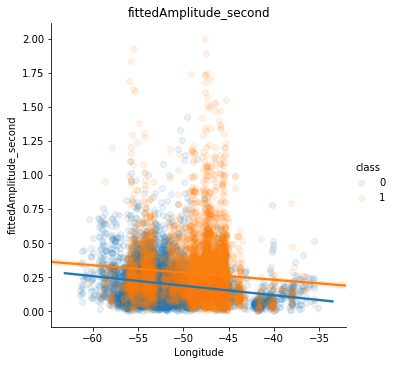

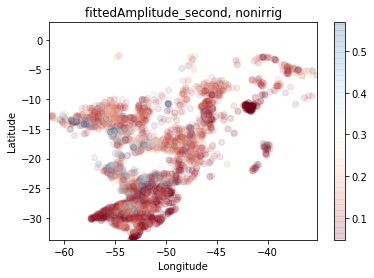

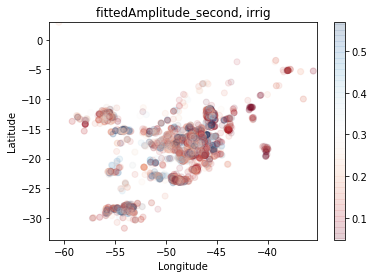

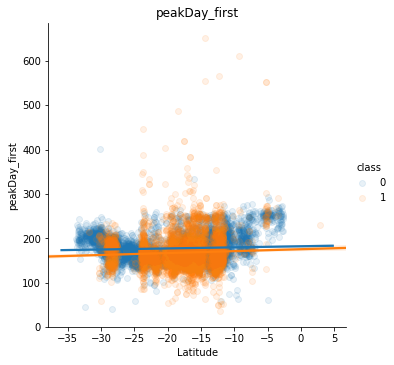

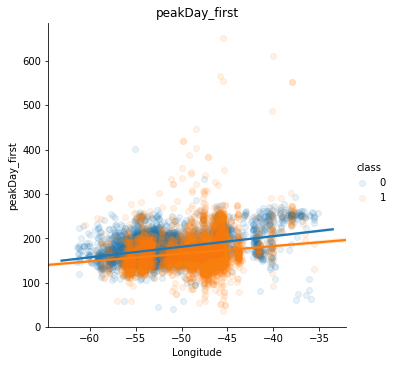

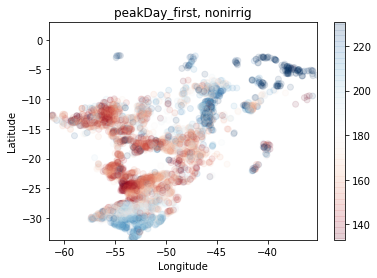

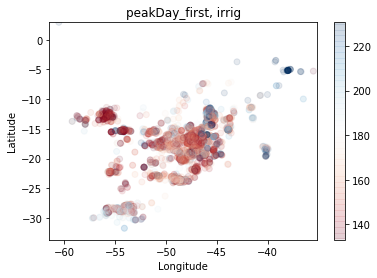

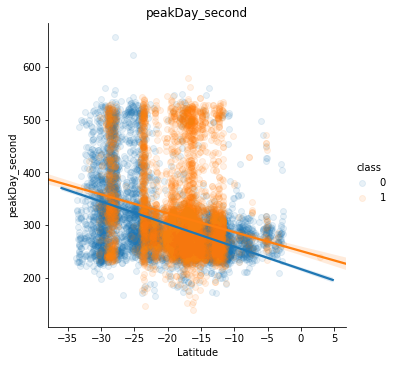

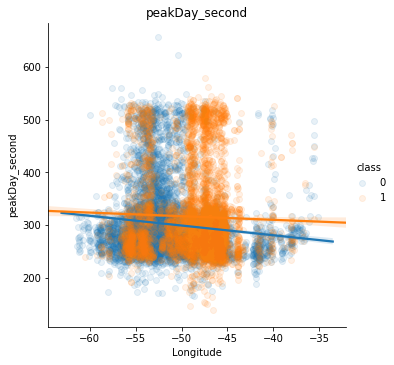

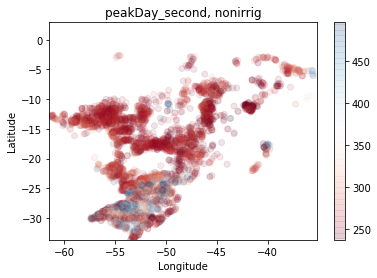

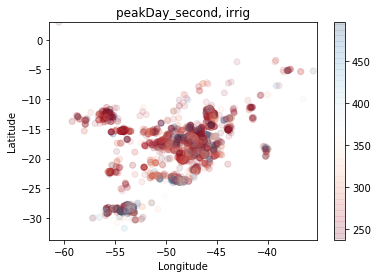

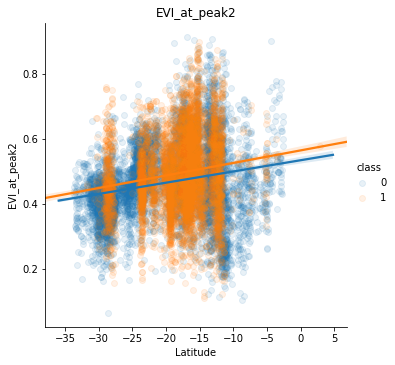

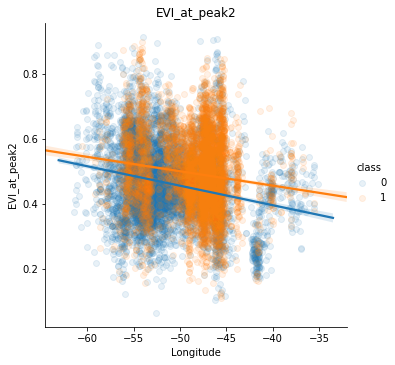

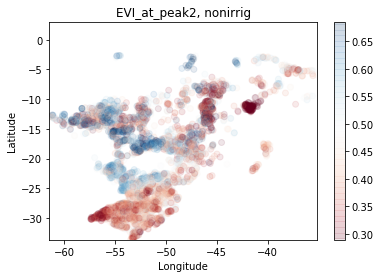

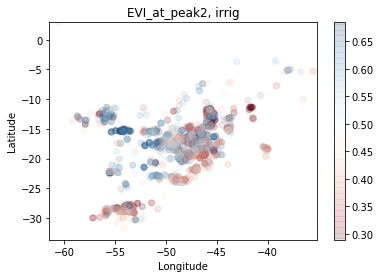

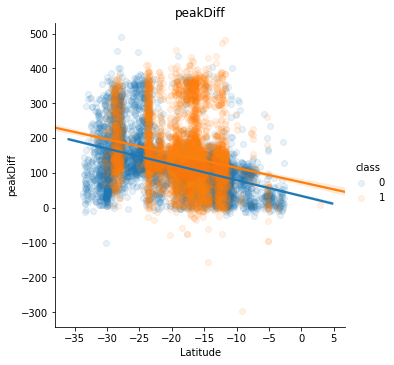

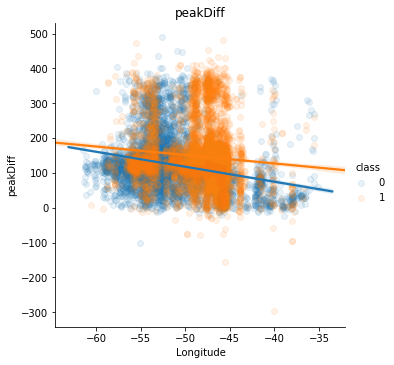

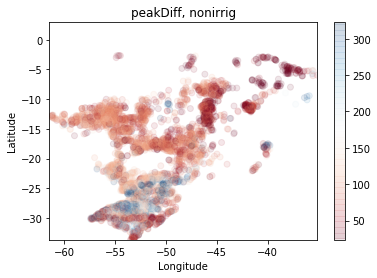

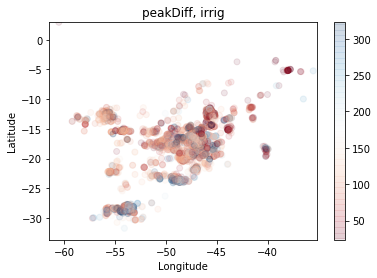

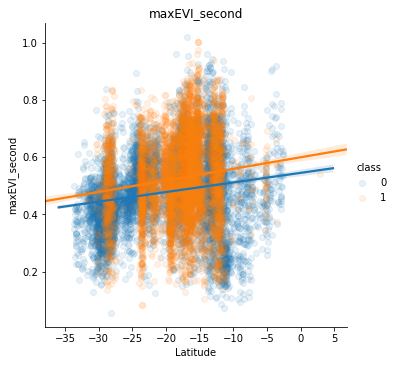

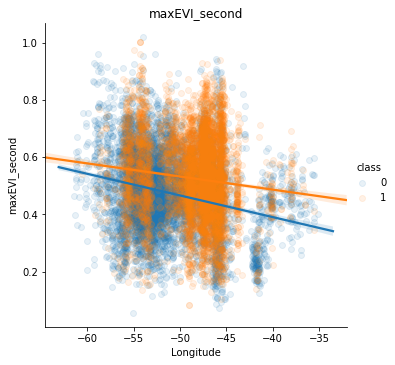

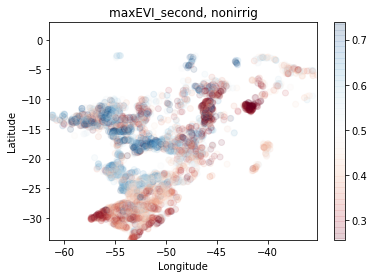

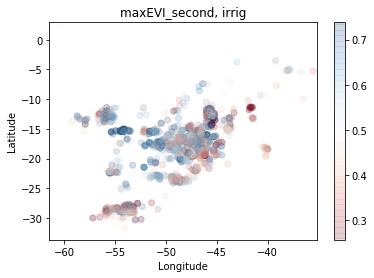

In [24]:
selected_phenospectral_cols = ['fittedAmplitude_first', 'fittedAmplitude_second', 'peakDay_first', 'peakDay_second', 
                               'EVI_at_peak2', 'peakDiff', 'maxEVI_second']
nonirrig = data[data['class_num'] == 0]
irrig = data[data['class_num'] == 1]
    
for colname in selected_phenospectral_cols:
    
    sns.lmplot(x = 'lat', y = colname, data = data, hue = 'class', scatter_kws = {'alpha': 0.1})
    plt.xlabel('Latitude')
    plt.ylabel(colname)
    plt.title(colname)
    plt.show()
    
    sns.lmplot(x = 'lon', y = colname, data = data, hue = 'class', scatter_kws = {'alpha': 0.1})
    plt.xlabel('Longitude')
    plt.ylabel(colname)
    plt.title(colname)
    plt.show()

    
    values = data[colname][~np.isnan(data[colname])]
    max_val = np.percentile(values, 95)# for plotting, get min and max for both irrigated and nonirrigated points
    min_val = np.percentile(values, 5) # take 5th and 95th percentiles to avoid outliers
    
    plt.scatter(x = 'lon', y = 'lat', c = colname, data = nonirrig, alpha = 0.1, vmin = min_val, vmax = max_val, cmap = 'RdBu')
    plt.title(colname + ', nonirrig')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    plt.xlim([data.lon.min(), data.lon.max()])
    plt.ylim([data.lat.min(), data.lat.max()])
    plt.show()

    
    plt.scatter(x = 'lon', y = 'lat', c = colname, data = irrig, alpha = 0.1, vmin = min_val, vmax = max_val, cmap = 'RdBu')
    plt.title(colname + ', irrig')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    plt.xlim([data.lon.min(), data.lon.max()])
    plt.ylim([data.lat.min(), data.lat.max()])
    plt.show()

Since the wet season progresses in a distinct spatial pattern, we may expect that phenological parameters for rainfed points will change in space more than irrigated points, as they're more vulnerable to climate.

There appear to be small changes in phenological values across lat and lon, and for certain phenological values the mean and slope are different between the two classes. However, part of the difference in behavior (especially across latitude) may be due to the fact that irrigated points don't extend as far in the north-south direction as nonirrigated points. Another confounder is that each latitude value will have a large range of phenological parameters to due variation in longitude, and vice versa. The spatial pattern must be described two dimensionally; it's very difficult to find a distinct spatial pattern along only one axis.

To find the features that best separate the two classes for each region, we perform a t-test for all features and report, for each region, the features with the most significant t statistics. We hypothesize that different regions will have a different set of 'best' features.

In [26]:
top_predictors = pd.DataFrame()
all_regions = regions.tolist() + ['Brazil']

for regionname in all_regions:
    region_results = t_test_results[t_test_results.region == regionname]
    region_results['abs_t_stat'] = region_results['t_stat'].abs()
    sorted_region_results = region_results.sort_values(by = ['abs_t_stat'], ascending = False).reset_index(drop = True)
    top_predictors[regionname] = sorted_region_results[0:10].feature

print(top_predictors)

                      SUL CENTRO-OESTE   NORDESTE                 SUDESTE  \
0  fittedAmplitude_second    mod_B0_44  mod_B0_60  fittedAmplitude_second   
1             EVI_at_min2     mod_B0_0  mod_B0_62                peakDiff   
2                mod_B0_0    mod_B0_46  mod_B0_42          peakDay_second   
3               mod_B0_46    mod_B0_91  mod_B0_61               mod_B0_87   
4               mod_B0_47    mod_B0_47  mod_B0_90               mod_B0_40   
5   fittedAmplitude_first     mod_B0_1  mod_B0_91               mod_B0_42   
6               mod_B0_66    mod_B0_90  mod_B0_88               mod_B0_89   
7               mod_B0_49    mod_B0_45  mod_B0_45               mod_B0_88   
8           maxEVI_second    mod_B0_89  mod_B0_41               mod_B0_86   
9            EVI_at_peak2    mod_B0_43  mod_B0_89               mod_B0_41   

         NORTE                  Brazil  
0     mod_B0_9  fittedAmplitude_second  
1    mod_B0_55               mod_B0_88  
2    mod_B0_12               

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


T-tests indicate that the irrigated/rainfed points in the southern area of Brazil (SUDESTE and SUD) are best separated by fittedAmplitude_second, along with other phenological parameters. Phenological parameters are less able to separate the two classes in other regions. In the center-west and northeast regions, EVI in the middle of the agricultural year (modis acquisition 40 - 47) and the end of the agricultural year (modis acquisition 88 - 91) separate the two classes better than any other times of the year. Of the phenological parameters, the height and time of the second peak is best able to separate the two classes. 

Finally, we use a plot to summarize the best times of year to differentiate the two classes.

[0, 46, 47, 66, 49]
[44, 0, 46, 91, 47, 1, 90, 45, 89, 43]
[60, 62, 42, 61, 90, 91, 88, 45, 41, 89]
[87, 40, 42, 89, 88, 86, 41]
[9, 55, 12, 58, 54, 10, 70, 57, 8]
[88, 88, 25, 25, 42, 42, 58, 58, 69]


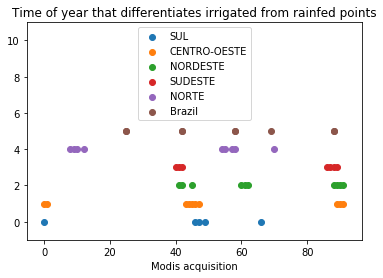

In [29]:
# plot the modis acquisition dates that best separate the two classes

for idx, regionname in enumerate(all_regions):
    top_EVI_times = [colname for colname in top_predictors[regionname] if colname.startswith('mod')]
    top_EVI_times = [int(colname.split('_')[2]) for colname in top_EVI_times]
    
    plt.scatter(top_EVI_times, [idx]*len(top_EVI_times), label = regionname)
    
    print(top_EVI_times)
plt.legend(loc='upper center')
plt.title('Time of year that differentiates irrigated from rainfed points')
plt.xlabel('Modis acquisition')
plt.ylim(-1, 11)
plt.show()

From the timeseries of the modis acquisitions that best separate the classes, we notice that there is a time between 40 and 50 that is consistently appropriate for separation, except for in the north; the north has a different seasonality, and the best modis acquisition times for separating the classes are 5 - 15 and 55 - 60. Additionally, the north and northeast also have a time from 55 - 65 that can separate the regions. The differences in the modis acquisition dates among the regions makes sense, because each region experiences different seasonalities.

Because the wet season in Brazil is quite long, there's not as much phenological or EVI difference between irrigated and nonirrigated pixels. In other words, this classification is much harder to do in Brazil than in the Sahara, where artificial water supply would make a large difference in crop growth. However, EVI at certain times of the year and certain peak characteristics can help to differentiate the two classes. Geographic features would improve accuracy for predictions in the training year, 2014, but would make the model less relevant for predicting changes in irrigated locations over time.